In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'
fit_outs_folder = './data/fit_outs/'
Idts_folder = './data/Idts/'
g2_folder = './data/g2/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1350, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load masks

In [2]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')
#bs_mask = np.load(masks_folder+'bs_mask_copper_foil_30um'+'.npy')  # beam-stop mask

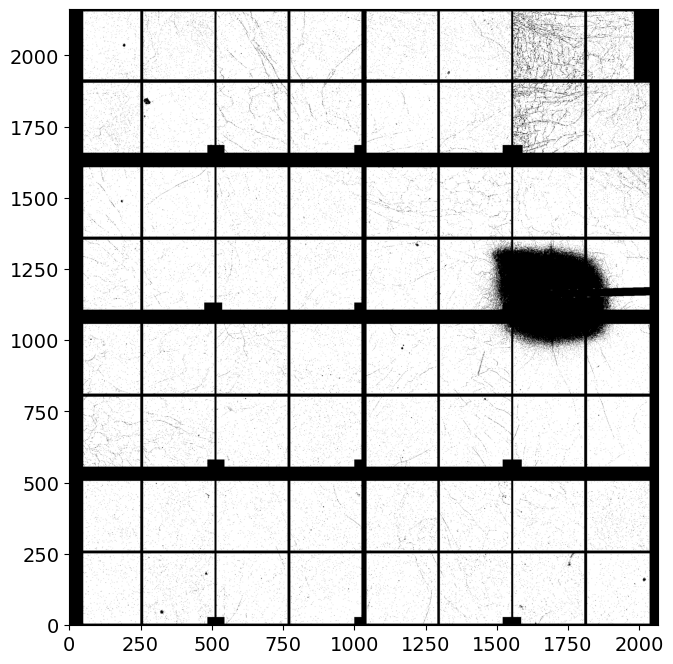

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

## XPCS scan (T = 30C Q =  0.19 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_4_30C, dataset 2, scan 3, 9.7 keV)

In [20]:
#######################################
sample_name = 'Vycor_10p25'
Ndataset = 1
Nscan = 15
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

#e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
e4m_data = ID10.load_dense_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

KeyError: 'fast_timer_period'

### Beamstop mask

################################################################################
Maximum count in the hull run -> 5523
# of pixels above Ith_high treshold ->  409 pixels (of 4471016 => 0.01 %)
################################################################################



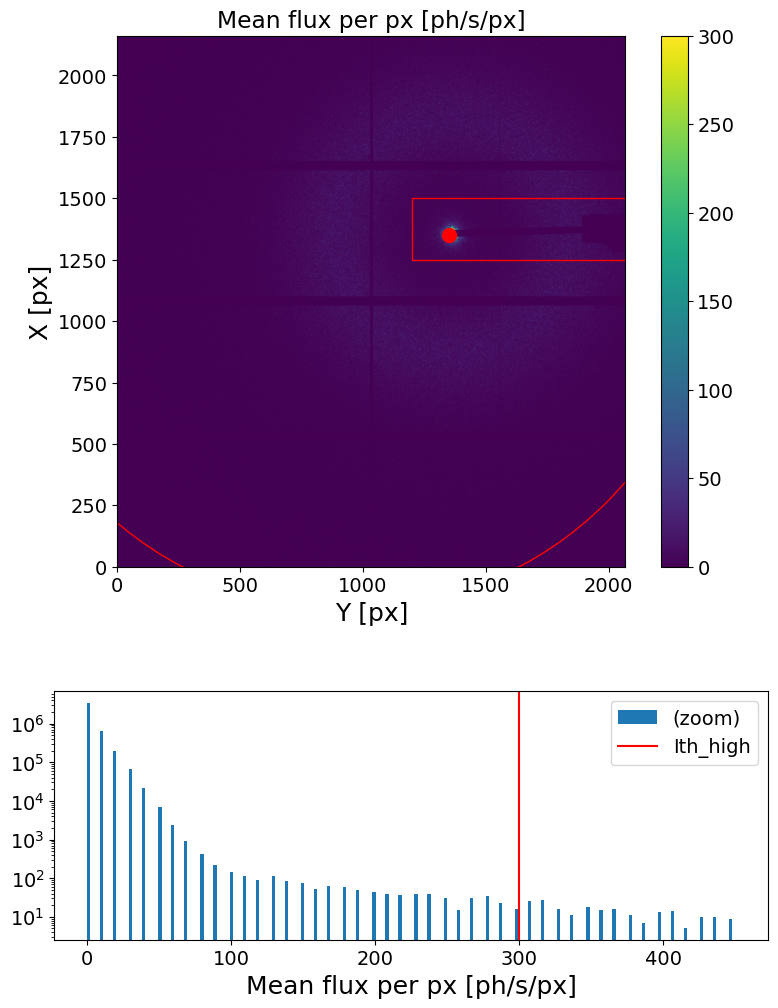

In [5]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1200, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=300, Nff=10, mask_geom=geom,)

#################################################
Masked area =  93.18454686809442 %
#################################################



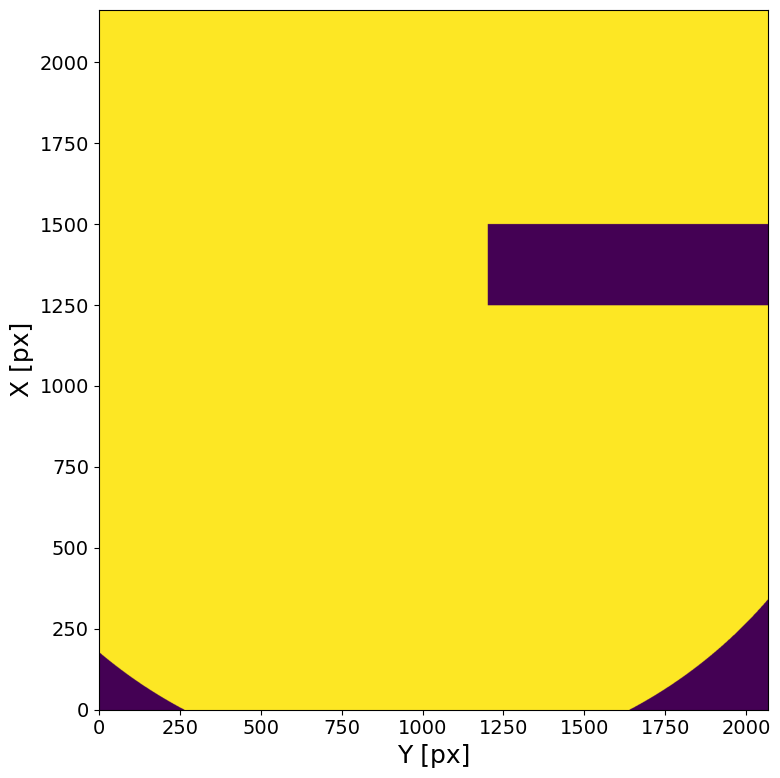

In [6]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom)

#### Q mask

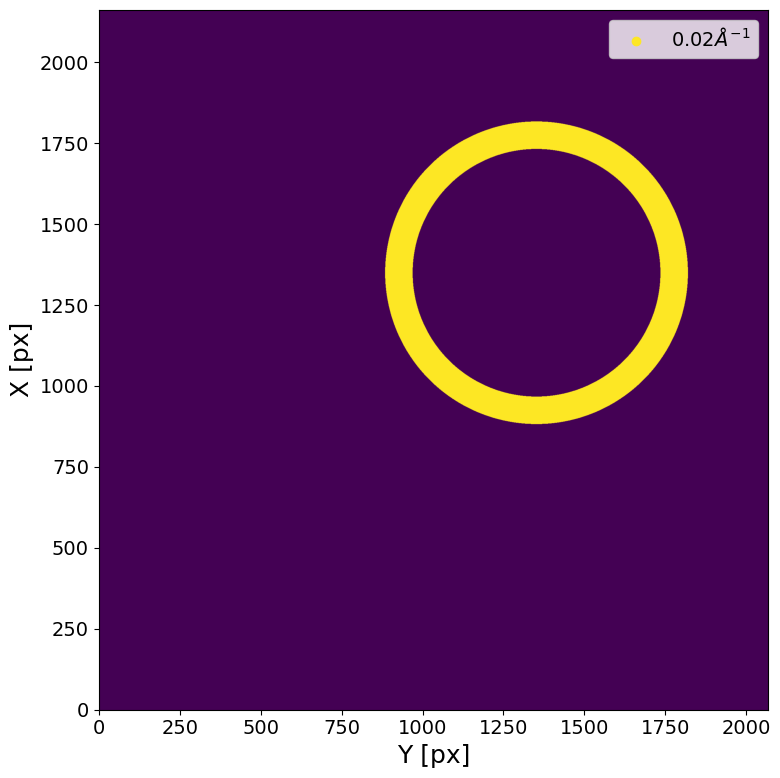

In [7]:
Qmask = XPCS.gen_Qmask(Ei, theta, .02, .002, Qmap_plot=False)

### Flux check

################################################################################
Maximum count in the hull run -> 2618
# of pixels above Ith_high treshold ->  0 pixels (of 4471016 => 0.0 %)
################################################################################



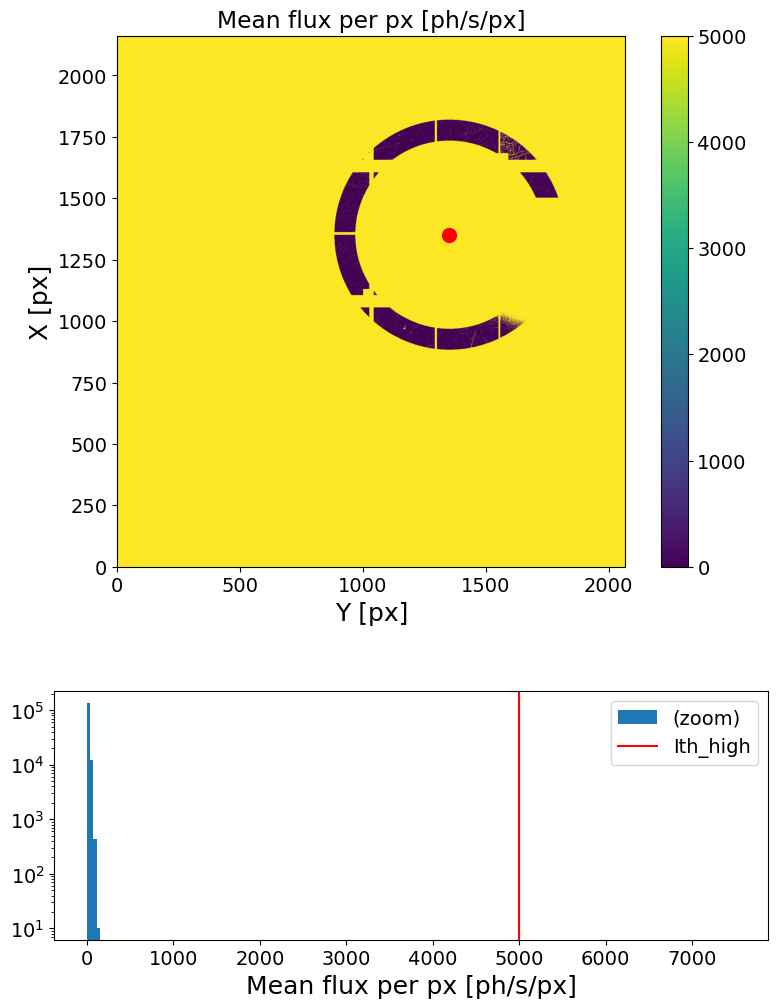

In [16]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= 5000, Nff=5, e4m_mask=mask)

### Intensity analysis

In [17]:
####################
Lbin = 1
Nstep = 10
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

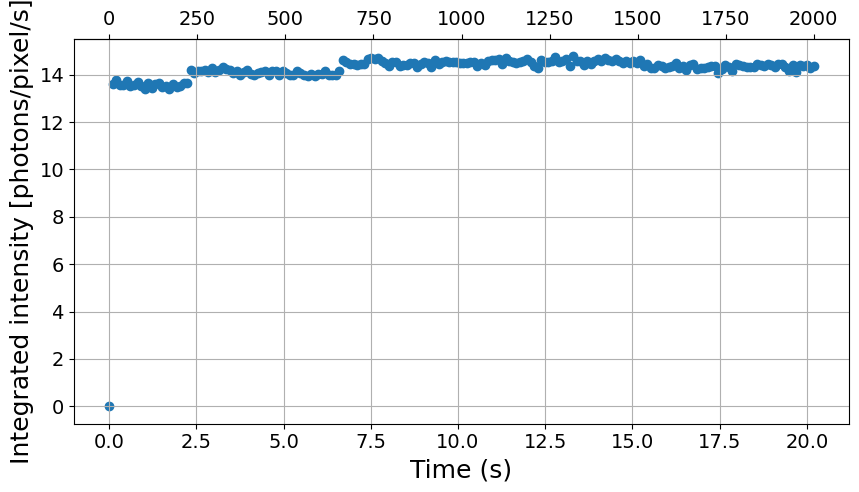

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
#plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [19]:
###################
Nfi = 20
Nff = None
Lbin = 10
Nbunch = 1
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin)

Loading frames ...
Done! (elapsed time = 5.9 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 4.98 s)
	 | 198 frames X 4471016 pixels
	 | sparsity = 2.47e-01
	 | memory usage (sparse.csr_array @ float64) = 2.444 GB
Masking data ...
Done! (elapsed time = 1.35 s)
	 | 198 frames X 149967 pixels
	 | sparsity = 7.21e-01
	 | memory usage (sparse.csr_array @ float64) = 0.239 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.4 s)
	 | 198 X 198 squared matrix
	 | memory usage (np.array @ float64) = 0.0 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.02 s)



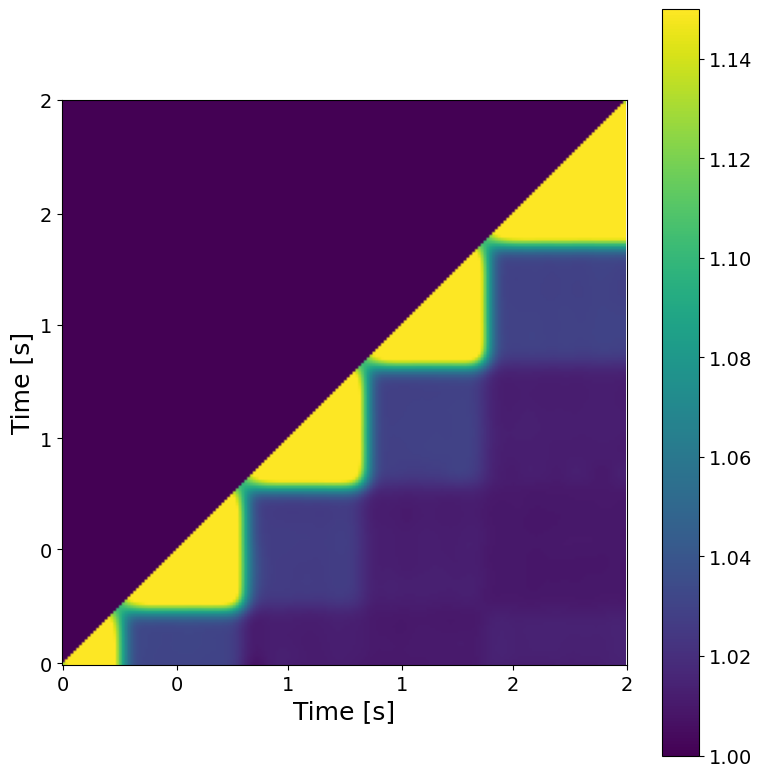

In [24]:
############################
t1, t2 = 0, 10000
vmin, vmax = 1.0, 1.15
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

In [21]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.0 s)



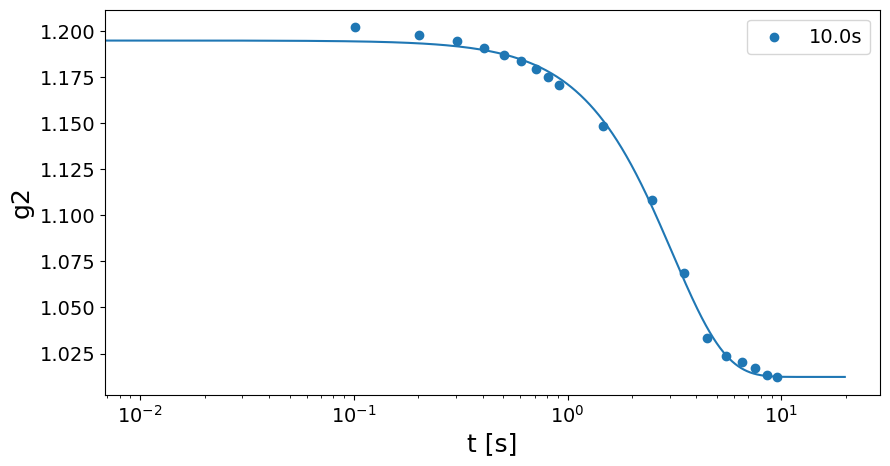

tau = 3.089606709875257 +/- 0.020102570058837508
beta = 1.7454182169470018 +/- 0.02712592301325058
c = 0.18259942300077903 +/- 0.0012056503392591559
y0 = 1.0123129631022287 +/- 0.00024097021980483792


In [22]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  